In [1]:
from IPython.display import display
import spot
import buddy
from buddy import bddtrue, bddfalse
spot.setup()

# Support for games

The support for games is currently quite rudimentary, as Spot currently only uses those games in `ltlsynt`.

In essence, agame is just an ω-automaton with a property named `state-player` that stores the player owning each state.  The players are named 0 and 1.  The player owning a state can decide what the next transition from this state should be.  The goal for player 1 is to force the play to be infinite and to satisfy the acceptance condition of the automaton, while the goal for player 0 is to prevent it by either forcing a finite play, or forcing an infinite play that does not satisfy the acceptance condition.

The support is currently restricted to games that use:
- `t` acceptance: all infinite run are accepting, and player 0 can only win if it manages to force a finite play (this requires reaching states without successors).
- max odd parity acceptance: player 0 can win if the maximal value seen infinitely often is even

# Creating games from scratch

Games can be [created like any automaton](https://spot.lrde.epita.fr/tut22.html).  
Using `set_state_players()` will fix the state owners.

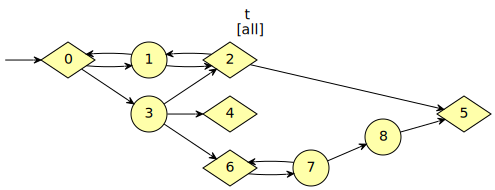

In [2]:
bdict = spot.make_bdd_dict();
game = spot.make_twa_graph(bdict)
game.new_states(9)
for (s, d) in ((0,1), (0, 3), 
               (1, 0), (1, 2),
               (2, 1), (2, 5),
               (3, 2), (3, 4), (3, 6),
               (6, 7),
               (7, 6), (7, 8),
               (8, 5)):
  game.new_edge(s, d, bddtrue)
spot.set_state_players(game, [True, False, True, False, True, True, True, False, False])
game.show('.g')  # Use "g" to hide the irrelevant edge labels.

The `set_state_players()` function takes a list of owner for each of the states in the automaton.  In the output,
states from player 0 use circles, ellispes, or rectangle with rounded corners (mnemonic: 0 is round) while states from player 1 have a losanse shape (1 has only straight lines). 


State ownership can also be manipulated by the following functions:

In [3]:
spot.get_state_players(game)

(True, False, True, False, True, True, True, False, False)

In [4]:
spot.get_state_player(game, 4)

1

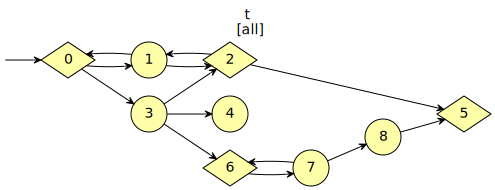

In [5]:
spot.set_state_player(game, 4, False)
game.show('.g')

# Solving a game

Solving a game is done my calling `solve_safety_game()` or `solve_parity_game()`.   This will attach two additional vectors into the game automaton: one vector stores the winner of each state, and one vector stores (memory-less) strategy for each state, i.e., the transition that should always be taken by the owner of this state in order to win.  

The return value of those function is simply the winner for the initial state.

In [6]:
spot.solve_safety_game(game)

True

Calling the `highlight_strategy()` function can be used to decorate the `game` automaton using the winning regions and strategies.  Below, green represent the winning region/strategy for player 1 and red those for player 0.

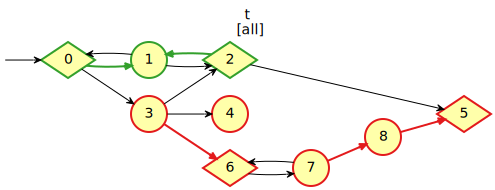

In [7]:
spot.highlight_strategy(game)
game.show('.g')

## Input/Output

An extension of the HOA format makes it possible to store the `state-player` property.  This allows us to read the parity game constructed by `ltlsynt` using `spot.automaton()` like any other automaton.

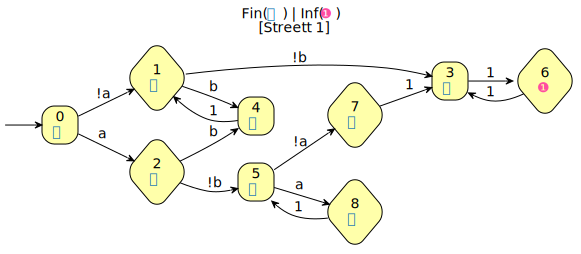

In [8]:
game = spot.automaton("ltlsynt --ins=a --outs=b -f '!b & GFa <-> Gb' --print-game-hoa |");
game

In the graphical output, player 0 is represented by circles (or ellipses or rounded rectangles depending on the situations), while player 1's states are diamond shaped.  In the case of `ltlsynt`, player 0 plays the role of the environment, and player 1 plays the role of the controler.

In the HOA output, a header `spot-state-player` (or `spot.state-player` in HOA 1.1) lists the owner of each state.

In [9]:
print(game.to_str('hoa'))

HOA: v1
States: 9
Start: 0
AP: 2 "b" "a"
acc-name: Streett 1
Acceptance: 2 Fin(0) | Inf(1)
properties: trans-labels explicit-labels state-acc colored complete
properties: deterministic
spot-state-player: 0 1 1 0 0 0 1 1 1
--BODY--
State: 0 {0}
[!1] 1
[1] 2
State: 1 {0}
[!0] 3
[0] 4
State: 2 {0}
[0] 4
[!0] 5
State: 3 {0}
[t] 6
State: 4 {0}
[t] 1
State: 5 {0}
[!1] 7
[1] 8
State: 6 {1}
[t] 3
State: 7 {0}
[t] 3
State: 8 {0}
[t] 5
--END--


Here is the solution of this particular game.

In [10]:
spot.solve_parity_game(game)

True

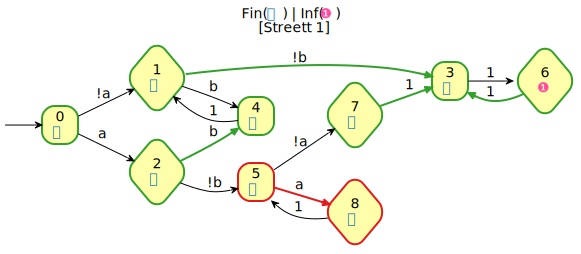

In [11]:
spot.highlight_strategy(game)

<h1> Creating a game from (multiple) formal specifications</h1>

<p>The new interface allows to create circuits from multiple strategies sharing input variables but having dissociated output sets. An example is given below.</p>

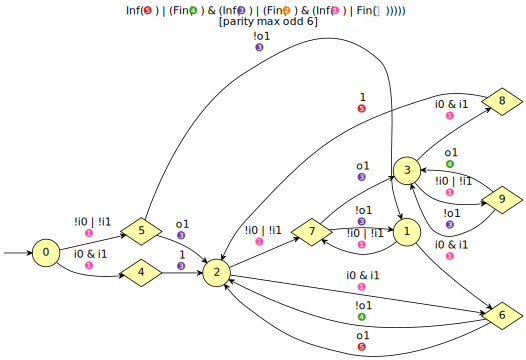

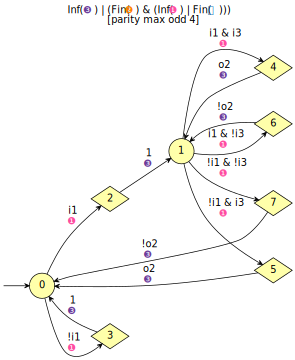

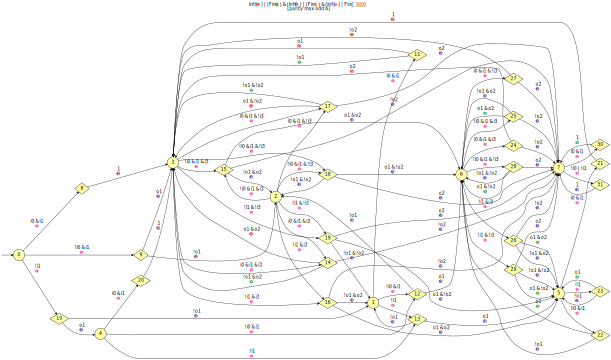

In [12]:
#Create two games that share the same bdd_dict
my_dict = spot.make_bdd_dict()

trans = spot.translator(my_dict)

f1_str = "GF(i0&i1) <-> GF(o1)"
f2_str = "G(i1 -> X(i3 <-> o2))"

f_str = f1_str + " & " + f2_str

gi = spot.game_info()
gi.s = spot.solver_DET_SPLIT
om = spot.option_map()

a1 = spot.create_game(f1_str, ["o1"], om, gi)
a2 = spot.create_game(f2_str, ["o2"], om, gi)
a = spot.create_game(f_str, ["o1", "o2"], om, gi)
display(a1)
display(a2)
display(a)

True
True
True


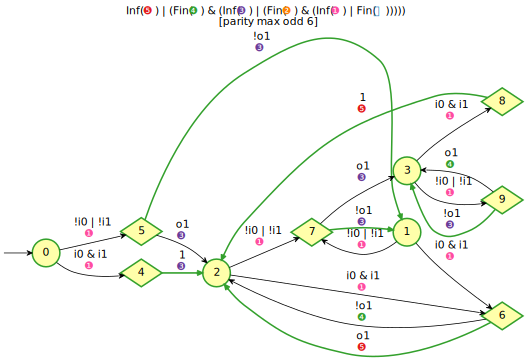

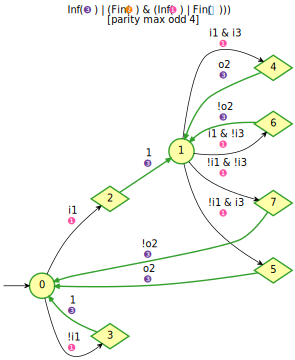

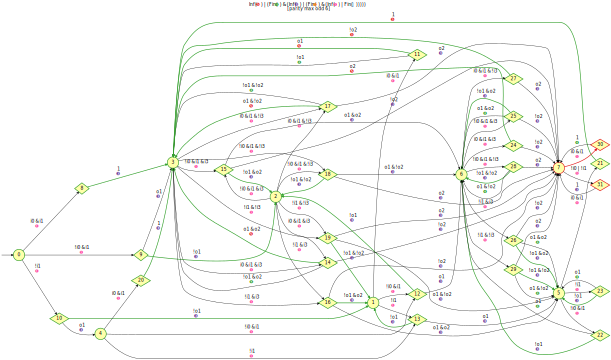

In [13]:
print(spot.solve_game(a1, gi))
print(spot.solve_game(a2, gi))
print(spot.solve_game(a, gi))
spot.highlight_strategy(a1)
spot.highlight_strategy(a2)
spot.highlight_strategy(a)
display(a1)
display(a2)
display(a)

2 4
2 6
3 12


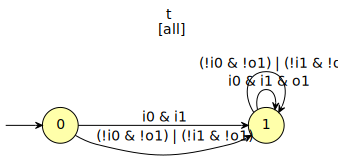

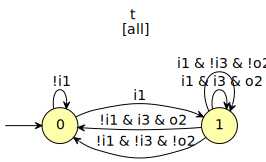

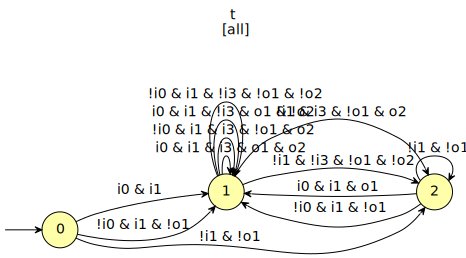

In [14]:
s1 = spot.create_strategy(a1, om, gi)
s2 = spot.create_strategy(a2, om, gi)
s = spot.create_strategy(a, om, gi)
print(s1.num_states(), s1.num_edges())
print(s2.num_states(), s2.num_edges())
print(s.num_states(), s.num_edges())
display(s1)
display(s2)
display(s)

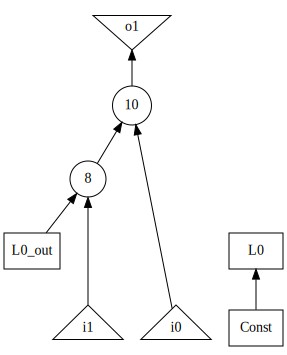

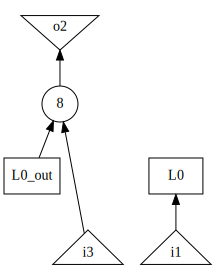

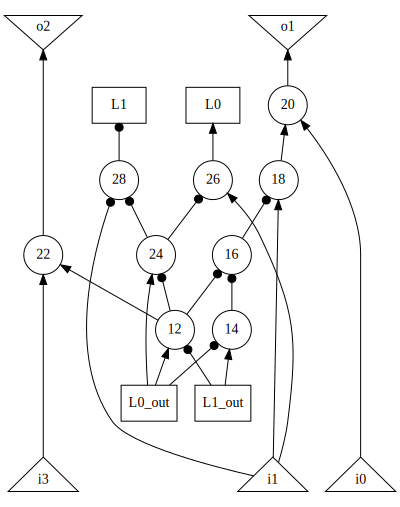

In [15]:
aig1 = spot.strategy_to_aig(s1, "ITE")
display(aig1)
aig2 = spot.strategy_to_aig(s2, "ITE")
display(aig2)
aig = spot.strategy_to_aig(s, "ITE")
display(aig)

In [16]:
print(type(s1))
print(type(s2))

<class 'spot.twa_graph'>
<class 'spot.twa_graph'>


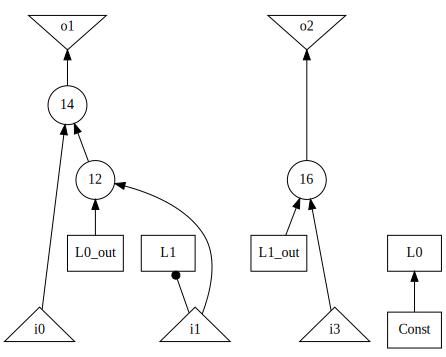

In [17]:
stratvec = spot.vector_const_twa_graph()
stratvec.push_back(s1)
stratvec.push_back(s2)
aig1aig2 = spot.strategies_to_aig(stratvec, "ITE")
aig1aig2

In [18]:
print(aig1.to_str())

aag 5 2 1 1 2
2
4
6 1
10
8 4 6
10 2 8
i0 i0
i1 i1
o0 o1



In [19]:
print(aig2.to_str())

aag 4 2 1 1 1
2
4
6 2
8
8 4 6
i0 i1
i1 i3
o0 o2



In [20]:
print(aig.to_str())

aag 14 3 2 2 9
2
4
6
8 26
10 28
20
22
12 8 11
14 9 10
16 15 13
18 4 17
20 2 18
22 6 12
24 8 13
26 4 25
28 5 25
i0 i0
i1 i1
i2 i3
o0 o1
o1 o2



In [21]:
print(aig1aig2.to_str())

aag 8 3 2 2 3
2
4
6
8 1
10 4
14
16
12 4 8
14 2 12
16 6 10
i0 i0
i1 i1
i2 i3
o0 o1
o1 o2



<h2>Reading an aiger-file</h2>

<p>Read an aiger file. Note that we do not support the full 
    <a href="http://fmv.jku.at/aiger/FORMAT.aiger">syntax</a>, but are restricted to:
    <ul>
        <li>Input variables start at index 2 and are consecutively numbered.</li>
        <li>Latch variables start at index (1 + #inputs) * 2 and are consecutively numbered.</li>
        <li>If inputs or outputs are named in the comments, they have to be alphabetically ordered</li>
    </ul>
</p>

In [22]:
#aiger file 
aag_txt = "aag 5 2 0 2 3\n2\n4\n6\n8\n6 9 11\n8 2 4\n10 3 5\ni0 a\ni1 b\no0 c\no1 d\n"
print(aag_txt)


aag 5 2 0 2 3
2
4
6
8
6 9 11
8 2 4
10 3 5
i0 a
i1 b
o0 c
o1 d



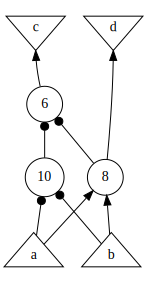

In [23]:
this_aig = spot.aig_parse_aag(aag_txt)
this_aig

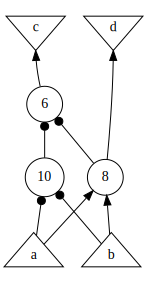

In [24]:
display(this_aig)

In [25]:
print(this_aig.gates())

((9, 11), (2, 4), (3, 5))


In [26]:
new_aag_text = this_aig.to_str()
print(new_aag_text)
assert new_aag_text == aag_txt

aag 5 2 0 2 3
2
4
6
8
6 9 11
8 2 4
10 3 5
i0 a
i1 b
o0 c
o1 d



In [27]:
a_dict = spot.make_bdd_dict()

s1 = spot.make_twa_graph(a_dict)
s2 = spot.make_twa_graph(a_dict)

i1 = buddy.bdd_ithvar(s1.register_ap("i1"))
o1 = buddy.bdd_ithvar(s1.register_ap("o1"))

i2 = buddy.bdd_ithvar(s2.register_ap("i2"))
o2 = buddy.bdd_ithvar(s2.register_ap("o2"))

s1.new_states(1)
s1.new_edge(0,0,i1&o1)

s2.new_states(1)
s2.new_edge(0,0,i2&o2)

spot.set_synthesis_outputs(s1, o1)
spot.set_synthesis_outputs(s2, o2)

display(s1)
display(s2)

AttributeError: module 'spot' has no attribute 'set_synthesis_outputs'

In [ ]:
aig1 = spot.strategy_to_aig(s1, "ISOP")
display(aig1)

In [ ]:
aig2 = spot.strategy_to_aig(s2, "ISOP")
display(aig2)

In [ ]:
stratvec = spot.vector_const_twa_graph()
stratvec.push_back(s1)
stratvec.push_back(s2)
aig1aig2 = spot.strategies_to_aig(stratvec, "ISOP")
display(aig1aig2)